### Shuai Ding

In [4]:
import pandas as pd
df = pd.read_csv("https://storage.googleapis.com/dataset-uploader/bbc/bbc-text.csv")

In [29]:
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


#### 1.Visualize the categories of your target variable and describe the dataset generally (the data includes news articles from the BBC news.)  A simple description is fine.

In [10]:
df['category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

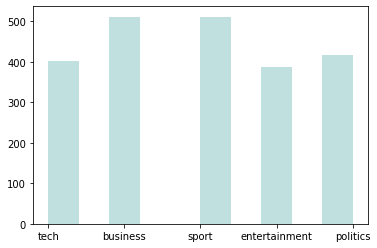

In [7]:
import numpy as np
import matplotlib.pyplot as plt
plt.hist(df['category'],  color="#c0e0e0")
plt.show()

This dataset contains five categories of BBC news. The number of data points are fairly equal so it's unnecessary to worry about imbalance between classes.  

#### 2) Preprocess your data such that each document in the data is represented as a sequence of equal length.

In [75]:
# Tokenize the data into one hot vectors
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 200  # We will cut reviews after 100 words
#training_samples = 200  # We will be training on 200 samples
#validation_samples =   # We will be validating on 10000 samples
max_words = 10000  # We will only consider the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text']) # converts words in each text to each word's numeric index in tokenizer dictionary.

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

print('Shape of data tensor:', data.shape)


Found 29726 unique tokens.
Shape of data tensor: (2225, 200)


In [76]:
# label encode and one-hot encode y
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(df['category'])
cat_labels = encoder.transform(df['category'])

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
cat_labels = cat_labels.reshape((2225, 1))
labels = encoder.fit_transform(cat_labels)

print('Shape of label tensor:', labels.shape)


Shape of label tensor: (2225, 5)


In [77]:
# Split the data into a training set and a test set
# But first, shuffle the data, since we started from data
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data, random_state=777, train_size=0.8)
train_cat, test_cat = train_test_split(labels, random_state=777, train_size=0.8)


In [78]:
print('Shape of data train_data:', train_data.shape)
print('Shape of data test_data:', test_data.shape)
print('Shape of train_cat:', train_cat.shape)
print('Shape of test_cat:', test_cat.shape)


Shape of data train_data: (1780, 200)
Shape of data test_data: (445, 200)
Shape of train_cat: (1780, 5)
Shape of test_cat: (445, 5)


#### 3)  Use the data to fit separate models to each of the following architectures:

A. A model with an embedding layer and dense layers (but w/ no layers meant for sequential data)

In [94]:
# Let's start with a model that ignores the sequential steps that make up each observation
from keras.layers import Dense, Embedding
from keras.models import Sequential
from keras.layers import Flatten, Dense

model = Sequential()
# Specify the size of your vocabulary (i.e.-10,000 terms)
# Specify the number of features you want to extract via fitting weights to your embedding matrix.
# We also specify the maximum input length to our Embedding layer
# so we can later flatten the embedded inputs 
model.add(Embedding(10000, 10, input_length=maxlen))
# After the Embedding layer, 
# our activations have shape `(samples, maxlen, 8)`.

# We flatten the 3D tensor of embeddings 
# into a 2D tensor of shape `(samples, maxlen * 8)`
model.add(Flatten())

# We add the classifier on top
model.add(Dense(512, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(train_data, train_cat,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)
score, acc = model.evaluate(test_data, test_cat,
                            batch_size=32)
print('Test score:', score)
print('Test accuracy:', acc)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 200, 10)           100000    
_________________________________________________________________
flatten_16 (Flatten)         (None, 2000)              0         
_________________________________________________________________
dense_29 (Dense)             (None, 512)               1024512   
_________________________________________________________________
dense_30 (Dense)             (None, 5)                 2565      
Total params: 1,127,077
Trainable params: 1,127,077
Non-trainable params: 0
_________________________________________________________________
Train on 1424 samples, validate on 356 samples
Epoch 1/10
1424/1424 [==============================] - 7s 5ms/step - loss: 1.5579 - acc: 0.3244 - val_loss: 1.4220 - val_acc: 0.4551
Epoch 2/10
1424/1424 [==============================] - 2s 1ms/step - loss: 0.7744 

#### B. A model using an Embedding layer with Conv1d Layers

In [93]:
from keras.layers import Dense, Embedding
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import MaxPooling1D
model = Sequential()
model.add(Embedding(10000, 10, input_length=maxlen))
model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
model.add(MaxPooling1D(pool_size=5))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(train_data, train_cat,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)
score, acc = model.evaluate(test_data, test_cat,
                            batch_size=32)
print('Test score:', score)
print('Test accuracy:', acc)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 200, 10)           100000    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 193, 32)           2592      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 38, 32)            0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 1216)              0         
_________________________________________________________________
dense_27 (Dense)             (None, 512)               623104    
_________________________________________________________________
dense_28 (Dense)             (None, 5)                 2565      
Total params: 728,261
Trainable params: 728,261
Non-trainable params: 0
_________________________________________________________________
Trai

#### C. A model using an Embedding layer with one sequential layer (LSTM or GRU)

In [87]:

from keras.layers import LSTM

model = Sequential()
model.add(Embedding(10000, 10,input_length=maxlen))
model.add(LSTM(10))

model.add(Dense(5, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(train_data, train_cat,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 200, 10)           100000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 10)                840       
_________________________________________________________________
dense_23 (Dense)             (None, 5)                 55        
Total params: 100,895
Trainable params: 100,895
Non-trainable params: 0
_________________________________________________________________
Train on 1424 samples, validate on 356 samples
Epoch 1/10
1424/1424 [==============================] - 22s 15ms/step - loss: 1.6049 - acc: 0.2303 - val_loss: 1.6021 - val_acc: 0.2528
Epoch 2/10
1424/1424 [==============================] - 19s 13ms/step - loss: 1.5829 - acc: 0.2633 - val_loss: 1.5726 - val_acc: 0.2584
Epoch 3/10
1424/1424 [==============================] - 18s 13ms/step - loss: 1.3

#### D. A model using an Embedding layer with stacked sequential layers (LSTM or GRU)

In [89]:

from keras.layers import LSTM

model = Sequential()
model.add(Embedding(10000, 10,input_length=maxlen))
model.add(LSTM(10, return_sequences=True))
model.add(LSTM(10, return_sequences=True))
model.add(LSTM(10))
          
model.add(Dense(5, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(train_data, train_cat,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 200, 10)           100000    
_________________________________________________________________
lstm_5 (LSTM)                (None, 200, 10)           840       
_________________________________________________________________
lstm_6 (LSTM)                (None, 200, 10)           840       
_________________________________________________________________
lstm_7 (LSTM)                (None, 10)                840       
_________________________________________________________________
dense_24 (Dense)             (None, 5)                 55        
Total params: 102,575
Trainable params: 102,575
Non-trainable params: 0
_________________________________________________________________
Train on 1424 samples, validate on 356 samples
Epoch 1/10
1424/1424 [==============================] - 68s 48ms/step - loss: 1.6064 - ac

#### E. A model using an Embedding layer with bidirectional sequential layers

In [91]:
from keras.layers import LSTM
from keras.layers import Bidirectional
model = Sequential()
model.add(Embedding(10000, 10,input_length=maxlen))
model.add(Bidirectional(LSTM(10)))

model.add(Dense(5, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(train_data, train_cat,
                    epochs=15,
                    batch_size=32,
                    validation_split=0.2)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 200, 10)           100000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 20)                1680      
_________________________________________________________________
dense_25 (Dense)             (None, 5)                 105       
Total params: 101,785
Trainable params: 101,785
Non-trainable params: 0
_________________________________________________________________
Train on 1424 samples, validate on 356 samples
Epoch 1/15
1424/1424 [==============================] - 43s 30ms/step - loss: 1.6016 - acc: 0.2303 - val_loss: 1.5967 - val_acc: 0.2416
Epoch 2/15
1424/1424 [==============================] - 49s 35ms/step - loss: 1.5510 - acc: 0.3006 - val_loss: 1.4681 - val_acc: 0.3876
Epoch 3/15
1424/1424 [==============================] - 32s 22ms/step - loss: 1.3

#### F. Now retrain your best model from C, D, and E using dropout (you may need to increase epochs!).

In [92]:
from keras.layers import LSTM
from keras.layers import Bidirectional
model = Sequential()
model.add(Embedding(10000, 10,input_length=maxlen))
model.add(Bidirectional(LSTM(10,dropout=0.2, recurrent_dropout=0.2)))

model.add(Dense(5, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(train_data, train_cat,
                    epochs=15,
                    batch_size=32,
                    validation_split=0.2)
score, acc = model.evaluate(test_data, test_cat,
                            batch_size=32)
print('Test score:', score)
print('Test accuracy:', acc)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 200, 10)           100000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 20)                1680      
_________________________________________________________________
dense_26 (Dense)             (None, 5)                 105       
Total params: 101,785
Trainable params: 101,785
Non-trainable params: 0
_________________________________________________________________
Train on 1424 samples, validate on 356 samples
Epoch 1/15
1424/1424 [==============================] - 45s 32ms/step - loss: 1.6065 - acc: 0.2296 - val_loss: 1.6035 - val_acc: 0.2331
Epoch 2/15
1424/1424 [==============================] - 31s 22ms/step - loss: 1.5886 - acc: 0.3097 - v

#### 4) Discuss 1) which model(s) performed best and speculate about 2) how you might try to further improve the predictive power of your model (e.g. Glove embeddings? More layers? Combining Conv1D with LSTM layers? More LSTM hidden nodes?)

##### A model using an embedding layer with bidirectional sequential layers and dropout performed best. In that model, loss was decreasing and val_loss was also decreasing. So I may increase epochs and I add more LSTM hidden nodes. 